In [1]:
from lenspyx.wigners import wigners
import numpy as np
import matplotlib.pyplot as plt
from plancklens import nhl, n0s, qresp

In [2]:
from os.path import join as opj
import os
from plancklens import utils


def camb_clfile_gradient(fname, lmax=None):
    """CAMB spectra (lenspotentialCls, lensedCls or tensCls types) returned as a dict of numpy arrays.
    Args:
        fname (str): path to CAMB output file
        lmax (int, optional): outputs cls truncated at this multipole.
    """
    cols = np.loadtxt(fname).transpose()
    ell = np.int_(cols[0])
    if lmax is None: lmax = ell[-1]
    assert ell[-1] >= lmax, (ell[-1], lmax)
    cls = {k : np.zeros(lmax + 1, dtype=float) for k in ['tt', 'ee', 'bb', 'te']}
    w = ell * (ell + 1) / (2. * np.pi)  # weights in output file
    idc = np.where(ell <= lmax) if lmax is not None else np.arange(len(ell), dtype=int)
    for i, k in enumerate(['tt', 'ee', 'bb', 'te']):
        cls[k][ell[idc]] = cols[i + 1][idc] / w[idc]
    return cls

cls_path = opj(os.environ['HOME'], 'jointmap', 'data')
#cls_path = opj("/Users/omard/Downloads/", 'giulio')
cls_unl = utils.camb_clfile(opj(cls_path, 'lensedCMB_dmn1_lenspotentialCls.dat'))
cls_len = utils.camb_clfile(opj(cls_path, 'lensedCMB_dmn1_lensedCls.dat'))
cls_grad = camb_clfile_gradient(opj(cls_path, 'lensedCMB_dmn1_lensedgradCls.dat'))
cls_rot = np.loadtxt(opj(cls_path, 'new_lensedCMB_dmn1_field_rotation_power.dat')).T[1]

from plancklens.utils import cli

ls = np.arange(cls_rot.size)
factor = cli(ls*(ls+1)/2)
cls_rot = cls_rot*factor**2.

In [3]:
def wignerc(cl1: np.ndarray, cl2:np.ndarray, s1: int, t1: int, s2: int, t2: int,
            lmax_out: int = -1):

    lmax1 = len(cl1) - 1
    lmax2 = len(cl2) - 1
    lmax_out = lmax1 + lmax2 if lmax_out < 0 else lmax_out
    lmax_tot = lmax1 + lmax2 + lmax_out
    so = s1 + s2
    to = t1 + t2
    if np.any(cl1) and np.any(cl2):
        npts = (lmax_tot + 2 - lmax_tot % 2) // 2
        if not 'tht wg %s' % npts in wigners.GL_cache.keys():
            wigners.GL_cache['tht wg %s' % npts] = wigners.get_thgwg(npts)
        tht, wg = wigners.GL_cache['tht wg %s' % npts]
        if np.iscomplexobj(cl1):
            xi1 = wigners.wignerpos(np.real(cl1), tht, s1, t1) + 1j * wigners.wignerpos(np.imag(cl1), tht, s1, t1)
        else:
            xi1 = wigners.wignerpos(cl1, tht, s1, t1)
            xi1 = np.exp(4*(-1 if t2 < 0 else 1)*xi1)
        if np.iscomplexobj(cl2):
            xi2 = wigners.wignerpos(np.real(cl2), tht, s2, t2) + 1j * wigners.wignerpos(np.imag(cl2), tht, s2, t2)
        else:
            xi2 = wigners.wignerpos(cl2, tht, s2, t2)
        xi1xi2w = xi1 * xi2 * wg
        if np.iscomplexobj(xi1xi2w):
            ret =wigners.wignercoeff(np.real(xi1xi2w), tht, so, to, lmax_out)
            ret = ret + 1j * wigners.wignercoeff(np.imag(xi1xi2w), tht, so, to, lmax_out)
            return ret
        else:
            return wigners.wignercoeff(xi1xi2w, tht, so, to, lmax_out)
    else:
        return np.zeros(lmax_out + 1, dtype=float)

In [4]:
import copy
import healpy as hp

def spit_out(cls_len_input, cl_ee_rotated, cl_bb_rotated, lensed_filter = True):

    caso_s4 = "" #cmb-s4
    caso_so = "_so"
    caso_spt = "_spt"

    caso = caso_s4

    SO_name = "so"
    SPT_name = "spt"
    S4_name = ""
    names = {caso_s4:S4_name, caso_so:SO_name, caso_spt:SPT_name}

    name = names[caso]
    cls_len = copy.deepcopy(cls_len_input)
    cls_len["ee"] = cl_ee_rotated
    cls_len["bb"] = cl_bb_rotated
    cls_len_filt = copy.deepcopy(cls_len_input) if lensed_filter else copy.deepcopy(cls_len)

    ns = 1
    ACB = 7
    ell = np.arange(0, len(cls_unl["tt"])+1)
    cls_alpha = 10**(-ACB)*2*np.pi/(ell*(ell+1))**ns
    cls_alpha[0] = 0

    #cls_unl["aa"] = cls_alpha

    lmax_cmb = 4000
    nlev_tdict = {caso_s4: 1., caso_so: 6., caso_spt: 1.6}
    beam_fwhm_dict = {caso_s4: 1., caso_so: 1.4, caso_spt: 1.4}

    nlev_t = nlev_tdict[caso]
    nlev_p = nlev_t*np.sqrt(2)
    beam_fwhm = beam_fwhm_dict[caso]
    cls_unl_fid = cls_unl
    lmin_cmb = 30
    lmin_blm, lmin_elm, lmin_tlm = lmin_cmb, lmin_cmb, lmin_cmb
    itermax = 10
    ret_curl = True

    lmax_qlm = 5120

    lt, le, lb = (np.arange(lmax_cmb + 1) >= lmin_tlm), (np.arange(lmax_cmb + 1) >= lmin_elm), (np.arange(lmax_cmb + 1) >= lmin_blm)

    transf = hp.gauss_beam(beam_fwhm / 180 / 60 * np.pi, lmax=lmax_cmb)
    ftl = utils.cli(cls_len_filt['tt'][:lmax_cmb + 1] + (nlev_t / 60. / 180. * np.pi) ** 2 / transf ** 2)*lt# isotropic approximation to the  T filtering, must match that applied to the data
    fel = utils.cli(cls_len_filt['ee'][:lmax_cmb + 1] + (nlev_p / 60. / 180. * np.pi) ** 2 / transf ** 2)*le # isotropic approximation to the E filtering
    fbl = utils.cli(cls_len_filt['bb'][:lmax_cmb + 1] + (nlev_p / 60. / 180. * np.pi) ** 2 / transf ** 2)*lb # isotropic approximation to the P filtering
    fals = {'tt':ftl, 'ee':fel, 'bb':fbl}
    dat_cls = {'tt':(cls_len['tt'][:lmax_cmb + 1] + (nlev_t / 60. / 180. * np.pi) ** 2 / transf ** 2)*lt,
                'ee': (cls_len['ee'][:lmax_cmb + 1] + (nlev_p / 60. / 180. * np.pi) ** 2 / transf ** 2)*le,
                'bb': (cls_len['bb'][:lmax_cmb + 1] + (nlev_p / 60. / 180. * np.pi) ** 2 / transf ** 2)*lb}

    cls_ivfs_arr = utils.cls_dot([fals, dat_cls, fals])

    cls_ivfs = dict()
    for i, a in enumerate(['t', 'e', 'b']):
        for j, b in enumerate(['t', 'e', 'b'][i:]):
            if np.any(cls_ivfs_arr[i, j + i]):
                cls_ivfs[a + b] = cls_ivfs_arr[i, j + i]

    return lmax_qlm, lmax_cmb, cls_ivfs, fals, cls_len
    

In [5]:
from iterativefg import utils as itu

bin_edges = np.arange(10, 4000, 30)

def cross_corr_coeff(a, b, base = 0, color = None, plot = True, ax = None, label = None, bin = False, linestyle = "-"):
    ls = np.arange(len(hp.alm2cl(a)))
    decorator = lambda x: itu.bin_theory(x, bin_edges) if bin else (ls, x)
    el, x =  decorator(hp.alm2cl(a, b))
    el, aa = decorator(hp.alm2cl(a, a))
    el, bb = decorator(hp.alm2cl(b, b))
    xcorr = x/np.sqrt(aa*bb)
    if plot:
        if ax is None:
            plt.plot(el, xcorr-base, color = color, label = label, ls = linestyle)
        else:
            ax.plot(el, xcorr-base, color = color, label = label, ls = linestyle)
    return xcorr

Using lenspyx alm2map


In [9]:
def get_noises(it, cls_w_ = None, cls_f_ = None):


    caso_s4 = "" #cmb-s4
    caso_so = "_so"
    caso_spt = "_spt"

    caso = caso_s4

    SO_name = "so"
    SPT_name = "spt"
    S4_name = "s4"
    names = {caso_s4:S4_name, caso_so:SO_name, caso_spt:SPT_name}

    name = names[caso]
    dir = f"{name}data/"
    print(dir)

    name = names[caso]
    dir = f"{name}data/"

    qe_key_A = f"x_p"
    qe_key_B = f"p_p"
    source_A = "x"
    source_B = "p"

    lmax_qlm = 5120

    
    fal, dat_delcls, cls_w, cls_f = np.load(f"{dir}fal_{it}.npy", allow_pickle=True).take(0), np.load(f"{dir}dat_delcls_{it}.npy", allow_pickle=True).take(0), np.load(f"{dir}cls_w_{it}.npy", allow_pickle=True).take(0), np.load(f"{dir}cls_f_{it}.npy", allow_pickle=True).take(0)
    cls_ivfs_arr = utils.cls_dot([fal, dat_delcls, fal])
    cls_ivfs = dict()

    if cls_w_ is not None:
        cls_w = cls_w_
    if cls_f_ is not None:
        cls_f = cls_f_

    for i, a in enumerate(['t', 'e', 'b']):
        for j, b in enumerate(['t', 'e', 'b'][i:]):
            if np.any(cls_ivfs_arr[i, j + i]):
                cls_ivfs[a + b] = cls_ivfs_arr[i, j + i]

    lmax_cmb = 4000

    #n_gg_A_B = nhl.get_nhl(qe_key_A, qe_key_B, cls_w, cls_ivfs, lmax_cmb, lmax_cmb, lmax_out=lmax_qlm)[1] #cross-noise
    n_gg_A_A = nhl.get_nhl(qe_key_A, qe_key_A, cls_w, cls_ivfs, lmax_cmb, lmax_cmb, lmax_out=lmax_qlm)[1] #auto-noise
    n_gg_B_B = nhl.get_nhl(qe_key_B, qe_key_B, cls_w, cls_ivfs, lmax_cmb, lmax_cmb, lmax_out=lmax_qlm)[0] #auto-noise
    r_gg_true_A = qresp.get_response(qe_key_A, lmax_cmb, source_A, cls_w, cls_f, fal, lmax_qlm=lmax_qlm)[1] #XX
    r_gg_true_A_B = qresp.get_response(qe_key_A, lmax_cmb, source_B, cls_w, cls_f, fal, lmax_qlm=lmax_qlm)[-1] #X A
    r_gg_true_B_A = qresp.get_response(qe_key_B, lmax_cmb, source_A, cls_w, cls_f, fal, lmax_qlm=lmax_qlm)[-2] # A X
    r_gg_true_B = qresp.get_response(qe_key_B, lmax_cmb, source_B, cls_w, cls_f, fal, lmax_qlm=lmax_qlm)[0] # A A 
    #N0_unbiased_A_B = n_gg_A_B * utils.cli(r_gg_true_A * r_gg_true_B)  # N0 of QE estimator after rescaling by Rfid / Rtrue to make it unbiased
    N0_unbiased_A_A = n_gg_A_A * utils.cli(r_gg_true_A * r_gg_true_A)  # N0 of QE estimator after rescaling by Rfid / Rtrue to make it unbiased
    N0_unbiased_B_B = n_gg_B_B * utils.cli(r_gg_true_B * r_gg_true_B)  # N0 of QE estimator after rescaling by Rfid / Rtrue to make it unbiased

    return N0_unbiased_A_A, r_gg_true_A, r_gg_true_B, r_gg_true_A_B, r_gg_true_B_A, N0_unbiased_B_B

In [10]:
lensed_filter = True

In [11]:
N0_unbiased_A_A, r_gg_true_A, r_gg_true_B, r_gg_true_A_B, r_gg_true_B_A, N0_unbiased_B_B = get_noises(0)

lmax_qlm = 5120
cls_alpha = cls_unl["pp"]
omega = cls_rot[:lmax_qlm+1]
alpha = cls_alpha[:lmax_qlm+1]

contamination_cross = cli(r_gg_true_A)*r_gg_true_A_B*alpha
contamination_auto = (cli(r_gg_true_A)*r_gg_true_A_B)**2*alpha
WQE = alpha/(alpha+N0_unbiased_B_B)
r_gg_true_B_QE = r_gg_true_B
N0QE = N0_unbiased_B_B
rho_QE = contamination_cross/np.sqrt((omega+N0_unbiased_A_A+contamination_auto)*alpha)

s4data/


/tmp/ipykernel_1827527/248303312.py:10: RuntimeWarning: invalid value encountered in divide
  WQE = alpha/(alpha+N0_unbiased_B_B)
/tmp/ipykernel_1827527/248303312.py:13: RuntimeWarning: invalid value encountered in divide
  rho_QE = contamination_cross/np.sqrt((omega+N0_unbiased_A_A+contamination_auto)*alpha)


In [12]:
qe_key = "p_p"
source = "p"
lmax = alpha.size
WthQE = alpha[:lmax]/(alpha[:lmax]+N0_unbiased_B_B[:lmax])


/tmp/ipykernel_1827527/2007121218.py:4: RuntimeWarning: invalid value encountered in divide
  WthQE = alpha[:lmax]/(alpha[:lmax]+N0_unbiased_B_B[:lmax])


In [13]:
N0_unbiased_A_A, r_gg_true_A, r_gg_true_B, r_gg_true_A_B, r_gg_true_B_A, N0_unbiased_B_B = get_noises(10)

lmax = lmax_qlm+1
lmax = cls_alpha[:lmax].size
WthMAP = cls_alpha[:lmax]/(cls_alpha[:lmax]+N0_unbiased_B_B[:lmax]) 

s4data/


/tmp/ipykernel_1827527/2704293791.py:5: RuntimeWarning: invalid value encountered in divide
  WthMAP = cls_alpha[:lmax]/(cls_alpha[:lmax]+N0_unbiased_B_B[:lmax])


In [14]:
#N0_unbiased_A_A, r_gg_true_A, r_gg_true_B, r_gg_true_A_B, r_gg_true_B_A, N0_unbiased_B_B = get_noises(0, cls_len_rot, cls_len_rot, cls_ivfs, fals)
N0_unbiased_A_A_0, r_gg_true_A_0, r_gg_true_B_0, r_gg_true_A_B_0, r_gg_true_B_A_0, N0_unbiased_B_B_0 = get_noises(0)

s4data/


In [15]:
N0_unbiased_A_A, r_gg_true_A, r_gg_true_B, r_gg_true_A_B, r_gg_true_B_A, N0_unbiased_B_B = get_noises(10)

omega = cls_rot[:lmax_qlm+1]
alpha = cls_alpha[:lmax_qlm+1]

N0_contaminant = N0_unbiased_B_B
contaminant = alpha
W = contaminant/(contaminant+N0_contaminant)
#W = WQE
rho_th_a = np.sqrt(W)
alpha_res_cross = (1-W)*contaminant
alpha_res = (1-rho_th_a**2)*contaminant

contamination_cross = cli(r_gg_true_A)*r_gg_true_A_B*alpha_res_cross
contamination_auto = (cli(r_gg_true_A)*r_gg_true_A_B)**2*alpha_res
r_gg_true_B_QE = r_gg_true_B
rho_MAP = contamination_cross/np.sqrt((omega+N0_unbiased_A_A+contamination_auto)*alpha)

s4data/


/tmp/ipykernel_1827527/3283241206.py:8: RuntimeWarning: invalid value encountered in divide
  W = contaminant/(contaminant+N0_contaminant)
/tmp/ipykernel_1827527/3283241206.py:17: RuntimeWarning: invalid value encountered in divide
  rho_MAP = contamination_cross/np.sqrt((omega+N0_unbiased_A_A+contamination_auto)*alpha)


In [16]:
from delensalot.core.iterator import statics

cmb = "po_only"

alpha_sim = hp.read_alm(f"/home/users/d/darwish/scratch/JOINTRECONSTRUCTION/{cmb}/simswalpha/sim_0000_plm.fits")
alpha_sim = utils.alm_copy(alpha_sim, lmax = 5000)

v = "p"
Nf = 2

dir = f"/home/users/d/darwish/scratch/JOINTRECONSTRUCTION/{cmb}_version_{v}_recs/p_p_sim0000{v}/"
it = 14
plms = statics.rec().load_plms(dir, itrs = [0, it-2, it])

mpisupport: False, pmisupport: False
disabling mpi


/tmp/ipykernel_1827527/2222553663.py:11: RuntimeWarning: invalid value encountered in divide
  xcorr = x/np.sqrt(aa*bb)


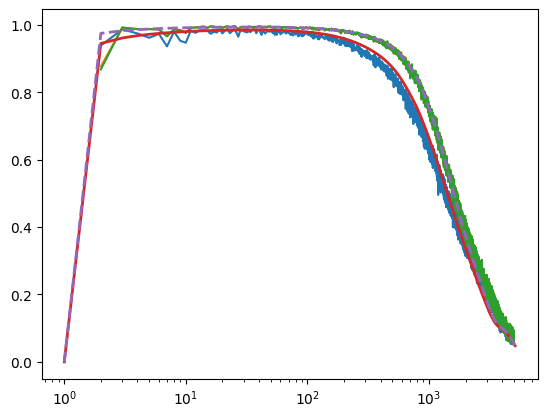

In [17]:
for p in plms:
    #cross = hp.alm2cl(np.split(p, Nf)[0], alpha_sim)
    #WF = cross/input
    #norm_alpha = hp.almxfl(alpha_sim, utils.cli(WF))
    cross_corr_coeff(np.split(p, Nf)[0], alpha_sim, plot = True)
    #WF = cross/input
    #plt.loglog(WF)
plt.plot(np.sqrt(WQE), lw = 2)
plt.plot(np.sqrt(W), lw = 2, ls = "--")
plt.xscale("log")
plt.show()

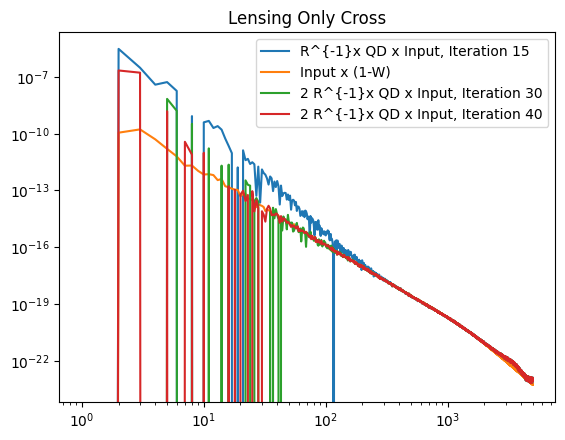

In [30]:
q = np.load(f"/home/users/d/darwish/scratch/JOINTRECONSTRUCTION/{cmb}_version_{v}_recs/p_p_sim0000{v}/plm_qd_partp015__sim0000_which_p.npy")
q = q[0]
q = utils.alm_copy(q, lmax = 5000)
plt.title("Lensing Only Cross")
plt.loglog(hp.alm2cl(q, alpha_sim)*utils.cli(r_gg_true_B[:5001]), label = "R^{-1}x QD x Input, Iteration 15")
plt.plot(hp.alm2cl(alpha_sim)*(1-W[:5001]), label = "Input x (1-W)")

q = np.load(f"/home/users/d/darwish/scratch/JOINTRECONSTRUCTION/{cmb}_version_{v}_recs/p_p_sim0000{v}/plm_qd_partp030__sim0000_which_p.npy")
q = q[0]
q = utils.alm_copy(q, lmax = 5000)

plt.loglog(hp.alm2cl(q, alpha_sim)*utils.cli(r_gg_true_B[:5001]), label = "2 R^{-1}x QD x Input, Iteration 30")

q = np.load(f"/home/users/d/darwish/scratch/JOINTRECONSTRUCTION/{cmb}_version_{v}_recs/p_p_sim0000{v}/plm_qd_partp040__sim0000_which_p.npy")
q = q[0]
q = utils.alm_copy(q, lmax = 5000)

plt.loglog(hp.alm2cl(q, alpha_sim)*utils.cli(r_gg_true_B[:5001]), label = "2 R^{-1}x QD x Input, Iteration 40")

plt.legend()

(1e-12, 1e-05)

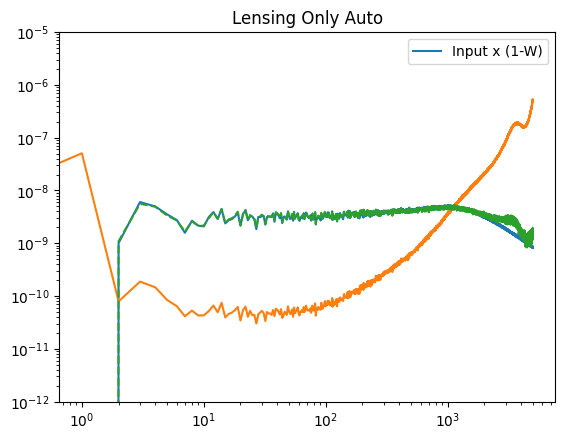

In [55]:
q = np.load(f"/home/users/d/darwish/scratch/JOINTRECONSTRUCTION/{cmb}_version_{v}_recs/p_p_sim0000{v}/plm_qd_partp030__sim0000_which_p.npy")
q = q[0]
q = utils.alm_copy(q, lmax = 5000)
plt.title("Lensing Only Auto")
ls = np.arange(hp.alm2cl(q).size)
factor = (ls*(ls+1)/2)**2
#plt.loglog(factor*hp.alm2cl(q)*utils.cli(r_gg_true_B[:5001])**2., label = "R^{-1}x QD x Input, Iteration 30")

q = np.load(f"/home/users/d/darwish/scratch/JOINTRECONSTRUCTION/{cmb}_version_{v}_recs/p_p_sim0000{v}/plm_qd_partp040__sim0000_which_p.npy")
q = q[0]
q = utils.alm_copy(q, lmax = 5000)
#plt.loglog(factor*hp.alm2cl(q)*utils.cli(r_gg_true_B[:5001])**2., label = "R^{-1}x QD x Input, Iteration 40")
plt.plot(factor*hp.alm2cl(alpha_sim)*(1-W[:5001]), label = "Input x (1-W)")
#plt.plot(factor*hp.alm2cl(alpha_sim), label = "Input")

q = np.load(f"/home/users/d/darwish/scratch/JOINTRECONSTRUCTION/{cmb}_version_{v}_recs/p_p_sim0000{v}/plm_qd_partp001__sim0000_which_p.npy")
q = q[0]
q = utils.alm_copy(q, lmax = 5000)
#plt.loglog(factor*hp.alm2cl(q)*utils.cli(r_gg_true_B[:5001])**2., label = "R^{-1}x QD x Input, Iteration 1")

gs = np.load("g_15.npy")
gs = np.split(gs, 2)[0]
plt.loglog(factor*hp.alm2cl(gs)*utils.cli(r_gg_true_B[:5001])**2.)
plt.loglog(factor*hp.alm2cl(gs, alpha_sim)*utils.cli(r_gg_true_B[:5001]), ls = "--")

plt.legend()
plt.ylim(1e-12, 1e-5)

In [ ]:
plt.loglog(factor*hp.alm2cl(q)*utils.cli(r_gg_true_B[:5001])**2., label = "R^{-1}x QD x Input, Iteration 40")


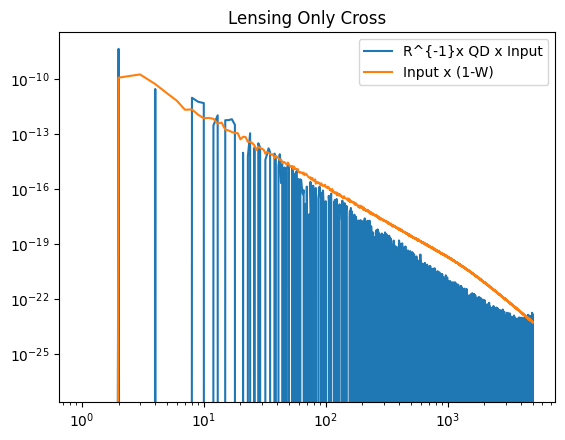

In [20]:
q = np.load(f"/home/users/d/darwish/scratch/JOINTRECONSTRUCTION/{cmb}_version_{v}_recs/p_p_sim0000{v}/plm_qd_partp015__sim0000_which_p.npy")
q = q[1]
q = utils.alm_copy(q, lmax = 5000)
plt.title("Lensing Only Cross")
plt.loglog(hp.alm2cl(q, alpha_sim)*utils.cli(r_gg_true_A[:5001]), label = "R^{-1}x QD x Input")
plt.plot(hp.alm2cl(alpha_sim)*(1-W[:5001]), label = "Input x (1-W)")
plt.legend()

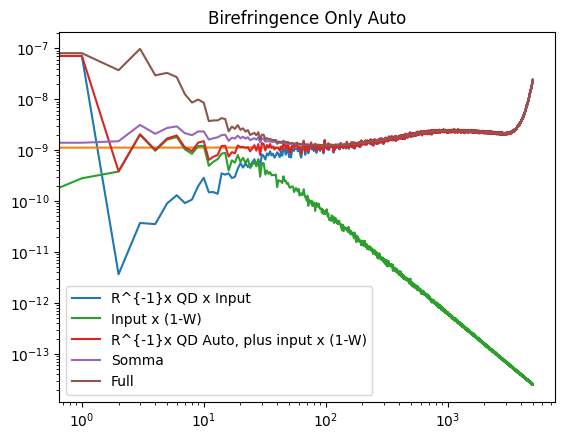

In [ ]:
q = np.load(f"/home/users/d/darwish/scratch/JOINTRECONSTRUCTION/a_new_version_{v}_recs/p_p_sim0000{v}/plm_qd_partp015__sim0000_which_a.npy")
q = utils.alm_copy(q, lmax = 5000)
plt.title("Birefringence Only Auto")
plt.loglog(hp.alm2cl(q)*utils.cli(r_B[:5001])**2., label = "R^{-1}x QD Auto")
plt.plot(utils.cli(r_B[:5001]))
plt.plot(hp.alm2cl(alpha_sim)*(1-Wa[:5001]), label = "Input x (1-W)")

cont = hp.alm2cl(alpha_sim)*(1-Wa[:5001])
plt.loglog(hp.alm2cl(q)*utils.cli(r_B[:5001])**2.+cont, label = "R^{-1}x QD Auto, plus input x (1-W)")

cont = hp.alm2cl(alpha_sim)*(1-Wa[:5001])
plt.loglog(utils.cli(r_B[:5001])+cont, label = "Somma")

cont = hp.alm2cl(alpha_sim)
plt.loglog(utils.cli(r_B[:5001])+cont, label = "Full")

plt.legend()

In [ ]:
(W-1)

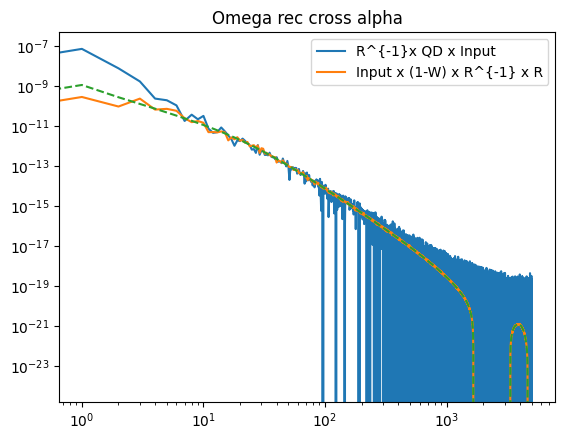

In [49]:
q = np.load(f"/home/users/d/darwish/scratch/JOINTRECONSTRUCTION/a_new_version_{v}_recs/p_p_sim0000{v}/plm_qd_partp015__sim0000_which_o.npy")
q = q[1]
q = utils.alm_copy(q, lmax = 5000)
plt.title("Omega rec cross alpha")
plt.loglog(-hp.alm2cl(q, alpha_sim)*utils.cli(r_A[:5001]), label = "R^{-1}x QD x Input")
plt.plot(-hp.alm2cl(alpha_sim)*(1-Wa[:5001])*utils.cli(r_A[:5001])*r_A_B[:5001], label = "Input x (1-W) x R^{-1} x R")
plt.plot(-contamination_cross, ls = "--")

plt.legend()

In [50]:
dirx = "/home/users/d/darwish/jointmap/jobs/"
n1_oa_QE = np.loadtxt(dirx+"n1_oa_QE.txt")
n1_oa_itr_10 = np.loadtxt(dirx+"n1_oa_itr_10.txt")
n1_oo_itr_10 = np.loadtxt(dirx+"n1_oo_itr_10.txt")
n1_op_itr_10 = np.loadtxt(dirx+"n1_op_itr_10.txt")

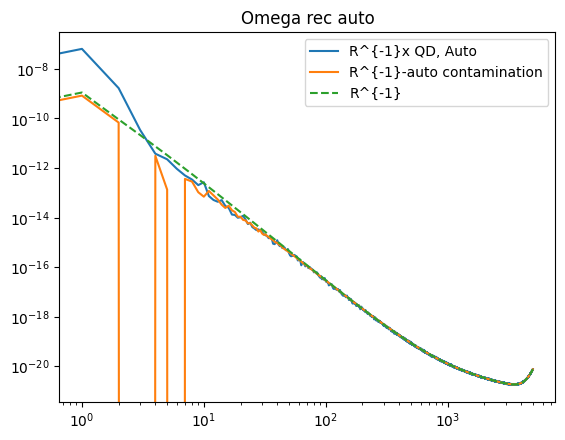

In [55]:

q = np.load(f"/home/users/d/darwish/scratch/JOINTRECONSTRUCTION/a_new_version_{v}_recs/p_p_sim0000{v}/plm_qd_partp015__sim0000_which_o.npy")
q = q[1]
q = utils.alm_copy(q, lmax = 5000)
plt.title("Omega rec auto")
plt.loglog(hp.alm2cl(q)*utils.cli(r_A[:5001])**2, label = "R^{-1}x QD, Auto")

residual = hp.alm2cl(alpha_sim)*(1-Wa[:5001])
cont = residual*(utils.cli(r_A[:5001])*r_A_B[:5001])**2
#cont = residual*(utils.cli(r_A[:5001])*r_A_B[:5001])
plt.loglog((utils.cli(r_A[:5001])-cont), label = "R^{-1}-auto contamination")
plt.loglog((utils.cli(r_A[:5001])), label = "R^{-1}", ls = "--")
#plt.plot(-hp.alm2cl(alpha_sim)*(1-Wa[:5001])*utils.cli(r_A[:5001])*r_A_B[:5001], label = "Input x (1-W) x R^{-1} x R")
#plt.plot(n1_oa_itr_10+n1_oo_itr_10)
#plt.plot(n1_op_itr_10, ls = "--")
plt.legend()

In [165]:
r = np.load("../jobs/r.npy")

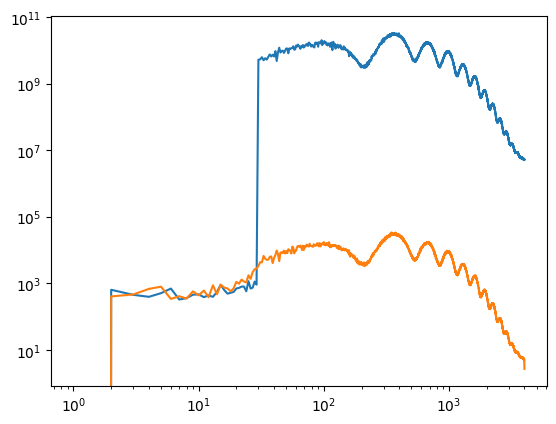

In [167]:
plt.loglog(hp.alm2cl(r[0]))
plt.loglog(hp.alm2cl(r[1]))

In [81]:
N0_unbiased_A_A, r_gg_true_A, r_gg_true_B, r_gg_true_A_B, r_gg_true_B_A, N0_unbiased_B_B = get_noises(0, cls_len_rot, cls_len_rot, cls_ivfs, fals)

/tmp/ipykernel_4191461/3405741830.py:12: RuntimeWarning: invalid value encountered in divide
  rho_MAP_ = contamination_cross/np.sqrt((omega+N0_unbiased_A_A+contamination_auto)*alpha)


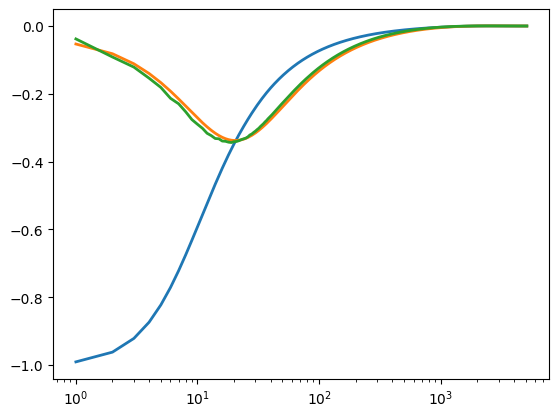

In [82]:
N0_contaminant = N0_unbiased_B_B
contaminant = alpha
W = contaminant/(contaminant+N0_contaminant)
#W = WQE
rho_th_a = np.sqrt(W)
alpha_res_cross = (1-W)*contaminant
alpha_res = (1-rho_th_a**2)*contaminant

contamination_cross = cli(r_gg_true_A)*r_gg_true_A_B*alpha_res_cross
contamination_auto = (cli(r_gg_true_A)*r_gg_true_A_B)**2*alpha_res
r_gg_true_B_QE = r_gg_true_B
rho_MAP_ = contamination_cross/np.sqrt((omega+N0_unbiased_A_A+contamination_auto)*alpha)

plt.plot(rho_QE, lw = 2)
plt.plot(rho_MAP_, lw = 2)
plt.plot(rho_MAP, lw = 2)
plt.xscale("log")

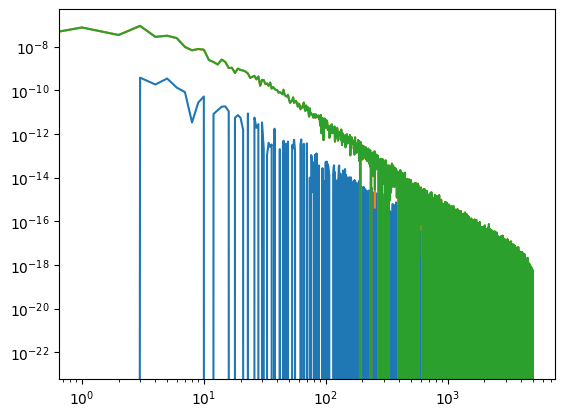

In [104]:
residual_rotation = plms[1]-plms[0]
cross = hp.alm2cl(residual_rotation, alpha_sim)
plt.loglog(cross)
plt.loglog(hp.alm2cl(plms[0], alpha_sim))
plt.loglog(hp.alm2cl(plms[1], alpha_sim))